In [1]:
import lightning.pytorch as pl
import numpy as np
import pandas as pd
import seaborn as sns
import torch
import torch.nn.functional as F
import yfinance as yf
from lightning.pytorch.callbacks import EarlyStopping, ModelCheckpoint, RichProgressBar
from lightning.pytorch.callbacks.progress.rich_progress import RichProgressBarTheme
from matplotlib import pyplot as plt
from pytorch_forecasting import TimeSeriesDataSet
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

%matplotlib inline
%config InlineBackend.figure_format='retina'

In [2]:
sp500 = yf.download("^GSPC", period="max", start="2010-1-1")
# sp500 = yf.download("000001.SZ", period="max", start="2023-1-1")
sp500.drop(columns=["Adj Close"], inplace=True)
df = sp500["Close"].to_frame()
df.head()

[*********************100%%**********************]  1 of 1 completed


,Close
Date,
2010-01-04,1132.989990
2010-01-05,1136.520020
2010-01-06,1137.140015
2010-01-07,1141.689941
2010-01-08,1144.979980


In [3]:
N_LAGS = 5
HORIZON = 1

In [4]:
class UnivariateSeriesDataModule(pl.LightningDataModule):
    def __init__(
        self,
        data: pd.DataFrame,
        n_lags: int,
        horizon: int,
        test_size: float = 0.2,
        batch_size: int = 16,
        feature_name: str = "",
    ) -> None:
        super().__init__()
        self.data = data
        self.n_lags = n_lags
        self.horizon = horizon
        self.test_size = test_size
        self.batch_size = batch_size
        self.feature_name = feature_name
        self.training: TimeSeriesDataSet
        self.validation: TimeSeriesDataSet
        self.test: TimeSeriesDataSet
        self.predict: TimeSeriesDataSet
        self.target_scaler = MinMaxScaler()
        self.setup()

    def preprocess_data(self):
        self.data["target"] = self.data[self.feature_name]
        self.data["time_index"] = np.arange(len(self.data))
        self.data["group_id"] = 0

    def split_data(self):
        time_indices = self.data["time_index"].values
        train_indices, test_indices = train_test_split(
            time_indices, test_size=self.test_size, shuffle=False
        )
        train_indices, val_indices = train_test_split(
            train_indices, test_size=0.1, shuffle=False
        )
        return train_indices, val_indices, test_indices

    def scale_target(self, df, indices):
        scaled_values = self.target_scaler.transform(df.loc[indices, ["target"]])
        df.loc[indices, "target"] = scaled_values

    def setup(self, stage=None) -> None:
        self.preprocess_data()
        train_indices, val_indices, test_indices = self.split_data()

        train_df = self.data.loc[self.data["time_index"].isin(train_indices)]
        val_df = self.data.loc[self.data["time_index"].isin(val_indices)]
        test_df = self.data.loc[self.data["time_index"].isin(test_indices)]
        predict_df = pd.concat([train_df, val_df, test_df])

        self.target_scaler.fit(train_df[["target"]])
        self.scale_target(train_df, train_df.index)
        self.scale_target(val_df, val_df.index)
        self.scale_target(test_df, test_df.index)

        self.training = TimeSeriesDataSet(
            train_df,
            time_idx="time_index",
            target="target",
            group_ids=["group_id"],
            max_encoder_length=self.n_lags,
            max_prediction_length=self.horizon,
            time_varying_unknown_reals=[self.feature_name],
            scalers={name: MinMaxScaler() for name in self.feature_name},
        )
        self.validation = TimeSeriesDataSet.from_dataset(
            self.training, val_df, stop_randomization=True
        )
        self.test = TimeSeriesDataSet.from_dataset(
            self.training, test_df, stop_randomization=True
        )
        self.predict = TimeSeriesDataSet.from_dataset(
            self.training, predict_df, stop_randomization=True
        )

    def train_dataloader(self):
        return self.training.to_dataloader(
            batch_size=self.batch_size,
            shuffle=True,
        )

    def val_dataloader(self):
        return self.validation.to_dataloader(
            batch_size=self.batch_size,
            shuffle=False,
        )

    def test_dataloader(self):
        return self.test.to_dataloader(
            batch_size=self.batch_size,
            shuffle=False,
        )

    def predict_dataloader(self):
        return self.predict.to_dataloader(
            batch_size=self.batch_size,
            shuffle=False,
        )

In [5]:
from torch import nn


class LSTMModel(pl.LightningModule):
    def __init__(
        self,
        input_dim: int = 1,
        hidden_dim: int = 128,
        num_layers: int = 2,
        output_dim: int = 1,
    ) -> None:
        super().__init__()
        self.hidden_dim = hidden_dim
        self.lstm = nn.LSTM(input_dim, hidden_dim, num_layers, batch_first=True)
        self.fc1 = nn.Linear(in_features=hidden_dim, out_features=16)
        self.fc2 = nn.Linear(in_features=16, out_features=output_dim)

    def forward(self, x):
        out, _ = self.lstm(x)
        out = out[:, -1, :]
        out = self.fc1(out)
        out = self.fc2(out)
        return out

    def training_step(self, batch, batch_idx):
        x, y = batch
        y_pred = self(x["encoder_cont"])
        loss = F.mse_loss(y_pred, y[0])
        self.log("train_loss", loss)
        return loss

    def test_step(self, batch, batch_idx):
        x, y = batch
        y_pred = self(x["encoder_cont"])
        loss = F.mse_loss(y_pred, y[0])
        self.log("test_loss", loss)

    def validation_step(self, batch, batch_idx):
        x, y = batch
        y_pred = self(x["encoder_cont"])
        loss = F.mse_loss(y_pred, y[0])
        self.log("validation_loss", loss)
        return loss

    def predict_step(self, batch, batch_idx):
        x, y = batch
        y_pred = self(x["encoder_cont"])
        y_pred = y_pred.detach().numpy()
        y_pred = self.trainer.datamodule.target_scaler.inverse_transform(y_pred)
        return y_pred

    def configure_optimizers(self):
        optimiser = torch.optim.Adam(self.parameters(), lr=0.001)
        return optimiser

In [6]:
datamodule = UnivariateSeriesDataModule(
    df, N_LAGS, HORIZON, feature_name="Close", batch_size=8
)

In [7]:
model = LSTMModel(input_dim=1, hidden_dim=64, num_layers=2, output_dim=1)

In [8]:
from torchinfo import summary

summary(model, input_size=(1, N_LAGS, 1))

Layer (type:depth-idx)                   Output Shape              Param #
LSTMModel                                [1, 1]                    --
├─LSTM: 1-1                              [1, 5, 64]                50,432
├─Linear: 1-2                            [1, 16]                   1,040
├─Linear: 1-3                            [1, 1]                    17
Total params: 51,489
Trainable params: 51,489
Non-trainable params: 0
Total mult-adds (M): 0.25
Input size (MB): 0.00
Forward/backward pass size (MB): 0.00
Params size (MB): 0.21
Estimated Total Size (MB): 0.21

In [9]:
from pytorch_lightning.loggers import TensorBoardLogger

logger = TensorBoardLogger("lightning_logs", name="index-prediction")

early_stop_callback = EarlyStopping(
    monitor="validation_loss", min_delta=1e-4, patience=10, verbose=False, mode="min"
)

model_checkpoint = ModelCheckpoint(
    dirpath="checkpoints/univariate-checkpoints",
    filename="{epoch}-{val_loss:.2f}-{other_metric:.2f}",
)
rich_progress_bar = RichProgressBar(
    theme=RichProgressBarTheme(
        description="green_yellow",
        progress_bar="green1",
        progress_bar_finished="green1",
        progress_bar_pulse="#6206E0",
        batch_progress="green_yellow",
        time="grey82",
        processing_speed="grey82",
        metrics="grey82",
        metrics_text_delimiter="\n",
        metrics_format=".3e",
    )
)
trainer = pl.Trainer(
    logger=logger,
    callbacks=[model_checkpoint, early_stop_callback, rich_progress_bar],
    max_epochs=500,
    accelerator="cpu",
)

GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/Users/raopend/Workspace/stock-index-prediction/.venv/lib/python3.10/site-packages/lightning/pytorch/trainer/setup.py:187: GPU available but not used. You can set it by doing `Trainer(accelerator='gpu')`.


In [10]:
trainer.fit(model=model, datamodule=datamodule)

/Users/raopend/Workspace/stock-index-prediction/.venv/lib/python3.10/site-packages/lightning/pytorch/callbacks/model_checkpoint.py:653: Checkpoint directory /Users/raopend/Workspace/stock-index-prediction/notebook/checkpoints/univariate-checkpoints exists and is not empty.


┏━━━┳━━━━━━┳━━━━━━━━┳━━━━━━━━┓
┃   ┃ Name ┃ Type   ┃ Params ┃
┡━━━╇━━━━━━╇━━━━━━━━╇━━━━━━━━┩
│ 0 │ lstm │ LSTM   │ 50.4 K │
│ 1 │ fc1  │ Linear │  1.0 K │
│ 2 │ fc2  │ Linear │     17 │
└───┴──────┴────────┴────────┘

Trainable params: 51.5 K                                                                                           
Non-trainable params: 0                                                                                            
Total params: 51.5 K                                                                                               
Total estimated model params size (MB): 0

Output()

/Users/raopend/Workspace/stock-index-prediction/.venv/lib/python3.10/site-packages/lightning/pytorch/trainer/connec
tors/data_connector.py:441: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider 
increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.

/Users/raopend/Workspace/stock-index-prediction/.venv/lib/python3.10/site-packages/lightning/pytorch/utilities/data
.py:77: Trying to infer the `batch_size` from an ambiguous collection. The batch size we found is 8. To avoid any 
miscalculations, use `self.log(..., batch_size=batch_size)`.

/Users/raopend/Workspace/stock-index-prediction/.venv/lib/python3.10/site-packages/lightning/pytorch/trainer/connec
tors/data_connector.py:441: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider 
increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.

In [11]:
trainer.test(model=model, datamodule=datamodule)

Output()

/Users/raopend/Workspace/stock-index-prediction/.venv/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:441: The 'test_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_loss         │   0.001995737897232175    │
└───────────────────────────┴───────────────────────────┘

[{'test_loss': 0.001995737897232175}]

In [12]:
trainer.validate(model=model, datamodule=datamodule)

Output()

/Users/raopend/Workspace/stock-index-prediction/.venv/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:441: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃      Validate metric      ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│      validation_loss      │   0.0004158091905992478   │
└───────────────────────────┴───────────────────────────┘

[{'validation_loss': 0.0004158091905992478}]

In [13]:
prediction = trainer.predict(model=model, datamodule=datamodule)

Output()

/Users/raopend/Workspace/stock-index-prediction/.venv/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:441: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.


In [14]:
scaler = datamodule.target_scaler

In [15]:
# scaler.data_max_, scaler.data_min_

In [ ]:
prediction

In [17]:
prediction = np.concatenate(prediction)
prediction = prediction.flatten()
prediction

array([1137.6837, 1140.2032, 1134.3545, ..., 4797.717 , 4823.2046,
       4872.6006], dtype=float32)

In [18]:
scaler = datamodule.target_scaler

In [19]:
# # scaler.inverse_transform(test).shape
actual_final = sp500["Close"].values[-len(prediction) :]
actual_final

array([1146.97998047, 1136.2199707 , 1145.68005371, ..., 5010.60009766,
       5070.54980469, 5071.62988281])

In [20]:
temp = pd.DataFrame(zip(prediction, actual_final), columns=["y_pred", "test"])

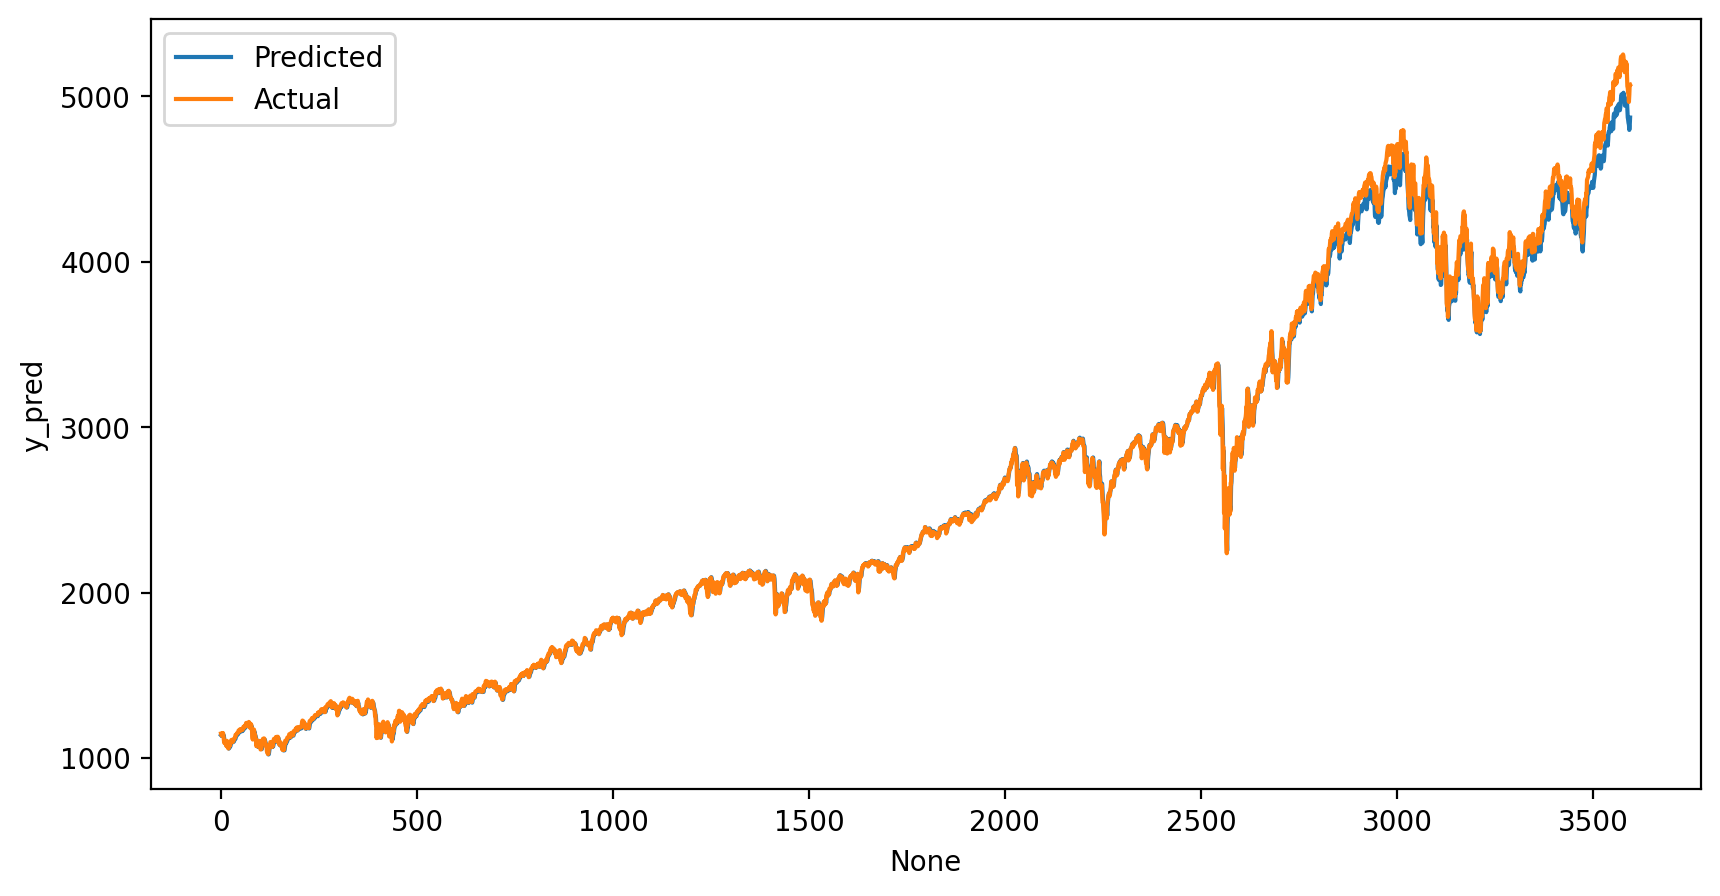

In [21]:
fig = plt.figure(figsize=(10, 5))
sns.lineplot(data=temp, x=temp.index, y="y_pred", label="Predicted")
sns.lineplot(data=temp, x=temp.index, y="test", label="Actual")
plt.show()

In [23]:
model.eval()
torch.onnx.export(
    model,
    torch.zeros(1, N_LAGS, 1),
    "./model/TimeSeries_LSTM.onnx",
    export_params=True,
)